# The Late Show with Stephen Colbert Analysis

## Standard Imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import seaborn as sns
from textblob import TextBlob
import statsmodels.formula.api as smf

plt.rcParams['figure.figsize'] = (20,6)

from bokeh.plotting import output_notebook, show
output_notebook(hide_banner=True)

from IPython.display import display, HTML
def printb(*args):
    s = " ".join([str(x) for x in args])
    display(HTML('<strong>%s</strong>' % s))

hover_cols = ['episode_number', 'title', 'air_date', 'rating', 'rating_count']

from analysis_utils import create_df
from lib.analysis_utils import plot_interactive_timeseries

## Load Data

In [2]:
episodes = create_df()
episodes.head()

,season,episode_number,rating,rating_count,air_date,title,description
0,1,1,7.4,101.0,2015-09-08,George Clooney/Governor Jeb Bush/Mavis Staples...,"Stephen Colbert succeeds David Letterman as ""L..."
1,1,2,7.4,62.0,2015-09-09,Scarlett Johansson/Elon Musk/Kendrick Lamar,Scarlett Johansson (Avengers: Age of Ultron (2...
2,1,3,8.2,71.0,2015-09-10,Vice President Joe Biden/Travis Kalanick/Toby ...,Vice President Joe Biden; Uber CEO Travis Kala...
3,1,4,7.3,45.0,2015-09-11,Amy Schumer/Stephen King/Troubled Waters,Amy Schumer (Trainwreck (2015)); author Stephe...
4,1,5,7.6,38.0,2015-09-14,Emily Blunt/Justice Stephen Breyer/The Dead We...,Actress Emily Blunt (Sicario (2015)); Supreme ...


## Distribution of Rating and Rating Count

Number of episodes with null rating (< 5 ratings)

In [3]:
episodes.rating.isnull().sum()

33

In [4]:
episodes[['rating', 'rating_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
rating,293.0,6.875427,0.747972,5.0,6.4,6.9,7.4,8.6
rating_count,293.0,11.262799,9.442465,5.0,7.0,9.0,12.0,101.0


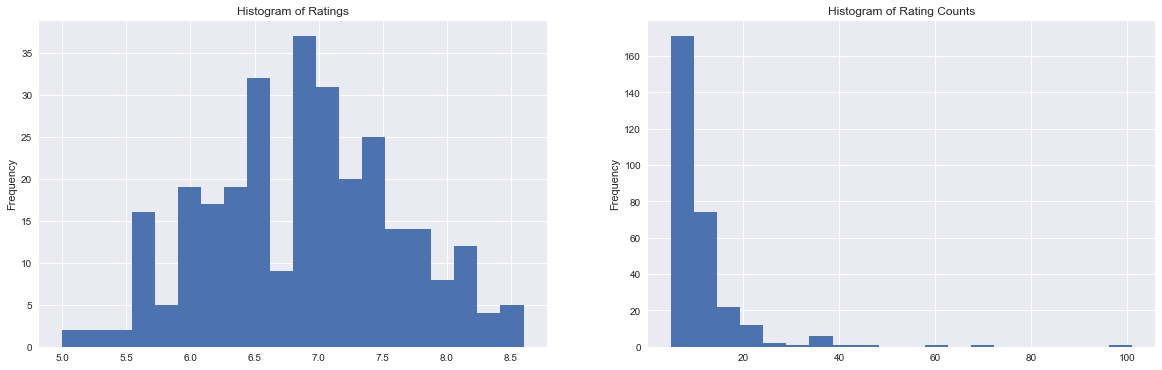

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

episodes.rating.plot(kind='hist', bins=20, ax=ax1, title="Histogram of Ratings")
episodes.rating_count.plot(kind='hist', bins=20, ax=ax2, title="Histogram of Rating Counts")

## Ratings over Time

In [6]:
p = plot_interactive_timeseries(x='air_date', y='rating', data=episodes, 
                                title="Ratings per Episode",
                               hover_cols=hover_cols)
show(p)

## Ratings Count over Time

In [7]:
p = plot_interactive_timeseries(x='air_date', y='rating_count', data=episodes, 
                                title="Number of Ratings per Episode",
                                hover_cols=hover_cols)
show(p)

## Ratings vs Rating Count

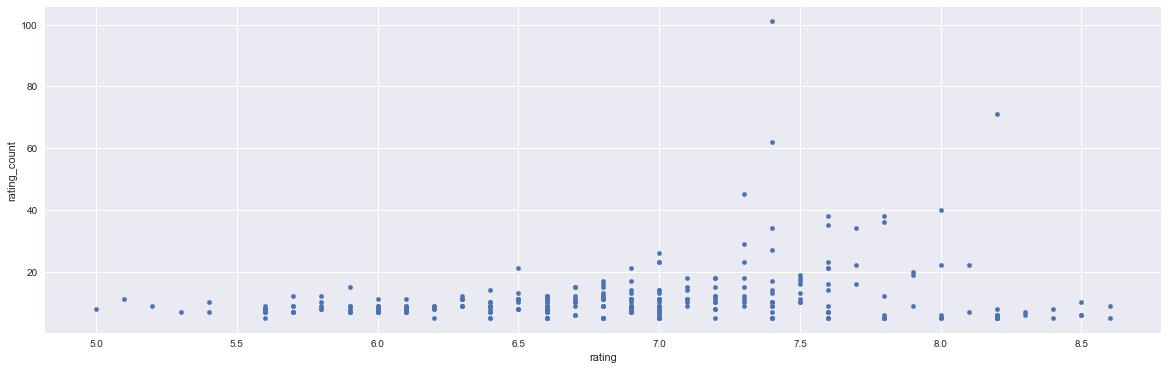

In [8]:
episodes.plot(kind='scatter', x='rating', y='rating_count')

## Sentiment Analysis

In [9]:
# rows = []
# for index, row in episodes.iterrows():
#     if pd.isnull(row.text): continue
#     blob = TextBlob(row.text)
#     sentiment = blob.sentiment
#     row = {"episode_number": row.episode_number, "polarity": sentiment.polarity, "subjectivity": sentiment.subjectivity}
#     rows.append(row)

# sentiment = pd.DataFrame(rows).set_index('episode_number')
# episodes = pd.concat([episodes.set_index('episode_number'), sentiment], axis=1).reset_index()
# episodes[['episode_number', 'air_date', 'polarity', 'subjectivity', 'rating', 'rating_count']].head()

In [10]:
# episodes.set_index('air_date').polarity.plot(style='.')
# episodes.set_index('air_date').subjectivity.plot(style='.')
# plt.legend()

In [11]:
# mod = smf.ols(formula='rating ~ subjectivity + polarity', data=episodes)
# res = mod.fit()
# res.summary()

## Subtitles of Most Recent Episodes

In [12]:
# for i, row in episodes.tail(5).iterrows():
#     if pd.isnull(row.text): continue
#     printb(row.episode_number, row.title)
#     print(row.text[:800] + '...')
#     print("\n----------------------------------\n")